# Schooling under Predation

#### TUE NGO - AARUSHI SHARMA - MARIO TSAVALOS

System Design, Integration & Control - Reactive Behaviors

![title](./cover.jpg)

# I - Introduction

In the natural world, animals exhibit collective behaviors by traveling in groups in a coordinated manner. This phenomenon occurs at both microscopic scales (bacteria) and macroscopic scales (vertebrates). It is called ***schooling*** in the case of fish, ***flocking*** in the case of birds, and ***herding*** in the case of grazing mammals. Any group of fish that stay together and swim in the same direction is schooling. 

Schooling helps fish to defend against predators and enhance foraging success. Using computers, those schooling behaviors of fish can be simulated by creating simple rules and combining them. This is known as emergent behavior and can be used to simulate representational group movements. We chose to simulate the behaviors of a school of mackerels under the predation of a shark.

# II - State of the art

The simulation and modeling of group traveling have been investigated by many previous studies. This flock motion seems simple and yet is visually complex. In his infamous work **“Flocks, Herds, and Schools: A Distributed Behavioral Model”**, Craig W. Reynolds explores flock movement as the aggregate result of the actions of individual animals, each acting exclusively based on the basis of its own local perception of the world. 

Reynolds developed a computational model of bird flocks and fish schools in this regard. In this model, agents (boids) form groups even though they do not have a group identity or even a concept of what a group is. The basic flocking model comprises three steering behaviors that explain how individual maneuvers based on the location and velocity of its neighbors: 

> ***1. Separation***: avoid collision amongst mates of the same group

> ***2. Alignment***: steer towards the average heading of local mates 

> ***3. Cohesion***: steer towards the centroid of local mates to stay within the group
    
More information: https://www.red3d.com/cwr/boids/.

![title](./boids.png)

In this project, we focus on the behaviors of an individual mackerel as reactive responses to the presence of other mackerels or a predator (shark). We took inspiration from these Reynolds rules to implement the schooling behaviors. However, our schooling behaviors cannot be directly implemented following the exact algorithms of Reynolds' boids, given the constraints imposed by local sensing and reactive behaviors. Generating the schooling behaviors without requiring the agent's understanding of a global state of the scene is the main challenge that adds value to our project. 

# III - Robotic simulation

The V-REP scene has been adapted to the underwater environment through different blue tones and textures. The water texture was provided by CoppeliaSim, whereas the textures of the "corals" are textures loaded from the web. They were dragged onto the surface of the existing tree objects. CoppeliaSim does not offer many possibilities to simulate different environments that include a variety of underwater objects. The "corals" and the "cups" were placed in this way in order to provide a free area and also to provide collision objects that the robots have to avoid.

![title](./scene-1.png)

*Our V-REP scene with 3 epucks on the top-left corner as 3 mackerels and the shark locates on the bottom-right corner.*

## 1 - Initialize session

In [1]:
from simulator_interface import open_session, close_session
simulator, prey1, prey2, prey3, predator = open_session(n_epucks=4)


In [2]:
# make sure to detach all behaviors and make all the robots stop
for e in simulator.robots:
    e.detach_all_behaviors()
    e.stop()
    

In [ ]:
# in case something goes wrong
close_session(simulator)


## 2 - Define species, motor constraints and internal needs

In [3]:
predator.species = "shark"
prey1.species = "mackerel"
prey2.species = "mackerel"
prey3.species = "mackerel"


### Constraints on motor skills

We would like to apply different motor constraints to different species. This helps us to easily distinguish a shark and a mackerel (they are all epucks in the V-REP scene), and also reflects reality in nature.

In [4]:
predator.max_speed = 15.0
prey1.max_speed = 10.0
prey2.max_speed = 10.0
prey3.max_speed = 10.0


### Variables for internal needs

We would like to specify the weight of each behavior while there are multiple behaviors running in parallel on the same robot, i.e. how much it will count in the averaging. This weighting can activate a behavior according to some internal drives of the robot, i.e. the animal will choose to satiate the need with higher intensity (urgency). For instance, a mackerel might split apart from the shoal mates if it's terribly hungry; but if it's just slightly hungry, it will prioritize staying within the group. The animal then evaluates the importance of needs based on a ranking system to represent the trade-offs when there are multiple needs with equal intensities: if the needs for collaboration and food are equivalent, the need with a higher importance level should be satisfied first.

The relationship between behavior weighting, internal needs and the relative importance of needs can be simplified as this equation:

> ***Weight of behavior = Intensity of need - Importance discount***


To do so, first we need to define the basic needs of both mackerels and sharks:

In [5]:
# the need to stay close to shoal mates
# regulate schooling behaviors

prey1.collaboration_need = 0.5
prey2.collaboration_need = 0.5
prey3.collaboration_need = 0.5

# cohesion threshold - a proximity value smaller than this means the shoal mate is too far away
th_c_min = 0.4
# separation threshold - a proximity value bigger than this means the shoal mate is too close
th_c_max = 0.6


In [6]:
# the need to run away from predator
# regulate escaping behaviors

prey1.security_need = 0.5
prey2.security_need = 0.5
prey3.security_need = 0.5


In [7]:
# regulate foraging behaviors: low energy level increases the need to catch food
predator.energy_level = 0.5
prey1.energy_level = 0.5
prey2.energy_level = 0.5
prey3.energy_level = 0.5

# predator has higher metabolic rate
predator.energy_increase = 0.2
predator.energy_decay = 0.02

# preys have lower metabolic rate
prey1.energy_increase = 0.1
prey1.energy_decay = 0.01
prey2.energy_increase = 0.1
prey2.energy_decay = 0.01
prey3.energy_increase = 0.1
prey3.energy_decay = 0.01


### Ranking system of needs

The animal evaluates the importance of a certain need based on an internal ranking system. Internal needs with lower importance level would only be considered if those with higher importance level are fulfilled. In the context of this project, we prioritize schooling over foraging and anti-predation over schooling. In reality, it could be different. 

The predator is only affected by its hunger, thus, there is no ranking system for it.

In [8]:
# we use discount values to indicate importance level which will be subtracted from the intensity of need
# the higher the importance, the lower the deduction value

# first priority
prey1.security_discount = 0.01
prey2.security_discount = 0.01
prey3.security_discount = 0.01

# second priority
prey1.collaboration_discount = 0.02
prey2.collaboration_discount = 0.02
prey3.collaboration_discount = 0.02

# third priority
prey1.foraging_discount = 0.03
prey2.foraging_discount = 0.03
prey3.foraging_discount = 0.03


## 3 - Define routines to track internal drives

These routines - which we call ***drives*** - helps the robot keep track of its internal needs and calculate the intensity of them. We adjust the intensity of need based on the fluctuations of threat intensity caused by external stimuli. In some cases, the animal will act in order to keep this value as low as possible. In other cases, the animal will try to keep this value within a desired, predefined range.

In [9]:
# affected by the presence of shoal mates 
# adjusting collaboration need 

def schooling_drive(robot): 
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # ensure distance to shoal mates to be within a range between cohesion and separation thresholds
    if left <= th_c_min: # the shoal mate is too far away
        robot.collaboration_need += abs(robot.collaboration_need - left) # increase the need
    if right <= th_c_min: # the shoal mate is too far away
        robot.collaboration_need += abs(robot.collaboration_need - right) # increase the need
    if left >= th_c_max: # the shoal mate is too close 
        robot.collaboration_need -= abs(robot.collaboration_need - left) # decrease the need
    if right >= th_c_max: # the shoal mate is too close
        robot.collaboration_need -= abs(robot.collaboration_need - right) # decrease the need

    robot.collaboration_need = min(1., max(robot.collaboration_need, 0.))
    

In [10]:
# affected by the presence of the predator 
# adjusting security need

def security_drive(robot): 
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "shark":
        left = 0
    if right_species != "shark":
        right = 0
    
    # ensure the predator to be as far as possible
    robot.security_need = left + right 
    
    robot.security_need = min(1., max(robot.security_need, 0.))
    

In [11]:
# affected by sphere consumption 
# adjusting energy level
# for both prey and predator

def foraging_drive(robot): 
    if robot.has_eaten(): # ensure the energy level to be as high as possible
        robot.energy_level += robot.energy_increase
    else:
        robot.energy_level -= robot.energy_decay  
         
    robot.energy_level = min(1., max(robot.energy_level, 0.))
    

## 4 - Reynolds-like schooling behaviors

### Rule of Separation:  `separation()`

Separation is the desire of a mackerel to steer away from an approaching schoal mate. In Reynolds' work, static collision avoidance and dynamic velocity matching are corresponding to each other and form this behavior. Together they guarantee that the individuals of a simulated group are free to navigate without running into each other. Static collision avoidance depends on the relative position of the shoal mates and disregards their velocities. The coordinating velocity of the animal is based only on velocity and ignores position. Static collision avoidance serves to build up the minimum required separation distance, while velocity coordination generally tends to maintain it.

In our case, we developed this behavior based on the basic `fear` Braitenbergs behavior. The distances to shoal mates are proximity values detected by the two proximity sensors of the robot. The velocity of a wheel will be mapped to the values of the sensor at the same side of the robot in an excitatory manner. The robot tends to steer away faster from a shoal mate when there is a higher chance of collision and slow down when reaching a safe separation distance. 

The weight of this behavior is modulated by the collaboration need (the closer the shoal mates, the lower the collaboration need, the **higher** the weight), and finally we applied a global discount to the whole group of schooling behaviors.

In [12]:
def separation(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # apply the appropriate sensorimotor connection
    left_activation = left 
    right_activation = right 
    
    # calculate the weight 
    weight = min(1., max((1 - robot.collaboration_need - robot.collaboration_discount), 0.))
    
    return left_activation, right_activation, weight


### Rule of Cohesion: `cohesion()` 

This rule causes the animal to move in a direction that moves it closer to the centroid of the nearby shoal mates. In Reynolds' work, if the group is maintained stable, the distance to shoal mates is approximately the same in all directions. In this case, the shoal centering urge is small. If a mackerel is on the boundary of the shoal, its neighbors are on one side. The centroid of the local shoal mates is displaced from the center of the neighbors toward the body of the shoal. Here the centering urge is stronger.

In our case, we developed this behavior partially based on the basic `love` Braitenbergs behavior. The distances to shoal mates are proximity values detected by the two proximity sensors of the robot. The velocity of a wheel will be mapped to the values of the sensor at the same side of the robot in an inhibitory manner. The robot will try to approach the shoal mates faster if it's too far away from them and slows down when it gets closer.

The weight of this behavior is also modulated by the collaboration need (the closer the shoal mates, the lower the collaboration need, the **lower** the weight), and finally we applied a global discount to the whole group of schooling behaviors.

In [13]:
def cohesion(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True) 
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # apply the appropriate sensorimotor connection
    left_activation = 1 - left 
    right_activation = 1 - right 
    
    # calculate the weight
    weight = min(1., max((robot.collaboration_need - robot.collaboration_discount), 0.))
    
    return left_activation, right_activation, weight


### Rule of Alignment: `alignment()`

We developed this rule in order to complement the `cohesion` rule regarding the centering movement towards the centroid of local shoal mates as well as to make sure all the members will have the tendency to navigate in the average heading of the shoal. 

In previous works, this rule is usually calculated based on the global orientation and position of the group as some sort of vectors. This requires the agent's understanding of the global state of the scene, which goes beyond the scope of local sensing and reactive behaviors. In our case, we came up with a solution of calculating the moving direction of a neighbor by comparing the immediate proximity value and the previous proximity value. The mackerel who goes in the opposite direction with the other two mates will be the one who needs to change its direction and follow the majority. We also allowed this rule to have the highest weight among the schooling behaviors, and finally, we applied the global schooling discount.

We observe that this behavior indeed helps the member steering towards the center point of the local mates and moving towards the average heading of them. But it cannot ensure that all the members will move in the same direction all the time (sometimes they will).

In [14]:
def alignment(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # save the previous readings
    prev_left = left
    prev_right = right
    
    # get new readings
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # calculate the weight based on the comparision of readings 
    weight = 0
    if prev_left < left and prev_right < right: # both other shoal mates are approaching the robot
        # switch on the behavior
        weight = 1 - robot.collaboration_discount # always has highest weight among schooling behaviors when being switched on
    
    # rotate to change direction if both other shoal mates are going in the opposite direction
    left_activation = 0
    right_activation = 1
    
    return left_activation, right_activation, weight


We also notice that an epuck only has 2 sensors in front of it, which may cause it unable to detect mates out of the local sight. Other mates will tend to ignore the lost one. The lost animal needs to look for the group by rotating itself until the schoal mates are within sight.

In [15]:
def mate_finding(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
        
    # calculate the weight based on the distance of shoal mates 
    weight = 0
    if left == 0 or right == 0: # losing sight of one of the shoal mates
        # switch on the behavior
        weight = 1 - robot.collaboration_discount # always has highest weight among schooling behaviors when being switched on
    
    # rotate until the shoal mates are within sight
    left_activation = 0
    right_activation = 1
        
    return left_activation, right_activation, weight


The combination of this `mate_finding` behavior and the `alignment` behavior can keep the agents together, eventually forming a triangular group. The emergent triangular formation is an interesting outcome of our solution since it expands and contracts as the cohesion and separation change in strength. 

![title](./scene-school-1.png)

*The 3 mackerels demonstrating schooling behavior, eventually form a triangular group.*

## 5 - Environmental dynamics

Now it's time to regulate multiple behaviors based on the interaction of the different internal drives and external stimuli.

![title](./scene-2.png)

*Schooling in the presence of spheres and predator.*

### Avoiding environmental obstacles: `obstacle_avoidance()` 

Real flocks and schools sometimes split apart to go around an obstacle. We developed this behavior based on the basic `shy` Braitenbergs behavior. The distances to objects (corals, walls, pillars, etc. ) are proximity values detected by the two proximity sensors of the robot. A wheel will be cross-wired to the sensor at the opposite side of the robot in an inhibitory manner. We allowed this rule to have the highest weight among all behaviors.


In [16]:
# for both prey and predator

def obstacle_avoidance(robot):
    left, right = robot.prox_activations(tracked_objects=["20cm", "Coral", "Cup"]) 
    left_activation = 1 - right
    right_activation = 1 - left 
    return left_activation, right_activation


### Anti-predation: `escape()` 

We developed this behavior based on the basic `fear` Braitenbergs behavior. The weight of this behavior is modulated by the security need (the closer the predator, the higher the security need, the **higher** the weight), and finally, we applied a global anti-predation discount. The mackerels will flee while trying to stay within-group or split apart and then reunite based on whether which need is more intense at the moment: security or collaboration.

In [17]:
def escape(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "shark":
        left = 0
    if right_species != "shark":
        right = 0
    
    # apply the appropriate sensorimotor connection
    left_activation = left 
    right_activation = right 
    
    # calculate the weight 
    weight = min(1., max((robot.security_need - robot.security_discount), 0.))
    
    return left_activation, right_activation, weight


![title](./scene-pred-3.png)

*Each mackerel try to steer away from the predator for its own sake and eventually split apart.*

![title](./scene-school-2.png)

*They perform grouping again when the predator is out of sight.*

### Foraging: `sphere_catching()`, `sphere_ignoring()` and `prey_hunting()` 

The foraging behaviors depend on the animal's hunger (energy level). The weight of this behavior is modulated by the energy level (the lower the energy level, the higher the foraging need, the **higher** the weight). 

When the animal is full, it tends to ignore and steer away from spheres. The weight of this behavior is also modulated by the energy level (the lower the energy level, the higher the foraging need, the **lower** the weight). 

And finally, we applied a global discount to all foraging behaviors.

The predator is allowed to catch spheres too in order to increase its energy level and survive through the whole simulation.

In [18]:
def sphere_catching(robot):
    left, right = robot.prox_activations(tracked_objects=["Sphere"])
    
    left_activation = right
    right_activation = left
    
    weight = 1 - robot.energy_level
    
    # apply foraging discount in the case of mackerel
    if robot.species == "mackerel":
        weight -= robot.foraging_discount
        
    return left_activation, right_activation, min(1., max(weight, 0.))

def sphere_ignoring(robot):
    left, right = robot.prox_activations(tracked_objects=["Sphere"])
    
    left_activation = left
    right_activation = right
    
    weight = robot.energy_level
    
    # apply foraging discount in the case of mackerel
    if robot.species == "mackerel":
        weight -= robot.foraging_discount
        
    return left_activation, right_activation, min(1., max(weight, 0.))


![title](./scene-forage-1.png)

*The mackerels try to catch detected food but still spend efforts in staying within group.*

![title](./scene-forage-2.png)

*They become more aggressive towards food over time and split apart to forage. They even compete for spheres.*

In nature, the predator also regulates its hunting behavior by the number of prey in a group: it will target the lonely fish rather than a collaborative school. We would like to imperfectly demonstrate this principle in our project, with the weight of hunting behavior calculated base on the energy level as well as the risk the predator has to tolerate while hunting multiple preys. Another interesting observation is that when two preys have equivalent distances to the predator, the predator will move forward in between them, very much reflecting the anti-predation benefit of schooling.

However, there is a limitation here. The epuck can only detect a maximum number of two objects, and it also cannot tell whether the two proximity sensors are sensing the same mackerel or not. Thus, in the case of a perpendicular attack (both sensors detecting the same mackerel), the predator will apply a risk when it shouldn't. We didn't plan to go further by allowing the predator to check the `id` or `position` of the prey to know, so we keep it as is for now.

In [19]:
def prey_hunting(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input and detect the number of preys
    prey_detected = 0
    if left_species == "mackerel":
        prey_detected += 1
    else:
        left = 0
    if right_species == "mackerel":
        prey_detected += 1
    else:
        right = 0
    
    # apply the appropriate sensorimotor connection
    left_activation = right 
    right_activation = left  
    
    # calculate the weight, taking into account the risk of hunting multiple preys
    risk = 0.2 if prey_detected > 1 else 0
    weight = min(1., max((1 - robot.energy_level - risk), 0.))
    
    return left_activation, right_activation, weight


![title](./scene-pred-1.png)

*The lonely mackerel is likely to be targeted by the predator.*

![title](./scene-pred-2.png)

*Gotcha!*

## 6 - Collect data for plotting

In [20]:
def robot_log(robot):
    robot.add_log("foraging", 1 - robot.energy_level)
    robot.add_log("position", robot.position())
    if robot.species == "mackerel":
        robot.add_log("collaboration", robot.collaboration_need)
        robot.add_log("security", robot.security_need)
        

# IV - Running simulation

## 1 - Attach and start all routines and behaviors

In [21]:
for e in simulator.robots:
    e.attach_behavior(sphere_catching, freq=10)
    e.attach_behavior(sphere_ignoring, freq=10)
    e.attach_behavior(obstacle_avoidance, freq=10)
    e.attach_routine(foraging_drive, freq=1)
    e.attach_routine(robot_log, freq=1)
    e.start_routine(robot_log)
    e.start_routine(foraging_drive)
    
    if e.species == "mackerel":
        
        e.attach_behavior(obstacle_avoidance, freq=10)
        
        e.attach_routine(schooling_drive, freq=1)
        e.attach_routine(security_drive, freq=1)
        e.attach_behavior(cohesion, freq=10)
        e.attach_behavior(separation, freq=10)
        e.attach_behavior(alignment, freq=10)
        e.attach_behavior(mate_finding, freq=10)
        e.attach_behavior(escape, freq=10)
        e.start_routine(schooling_drive)
        e.start_routine(security_drive)
    
    if e.species == "shark":
        e.attach_behavior(prey_hunting, freq=10)

Routine robot_log started
Routine foraging_drive started
Routine schooling_drive started
Routine security_drive started
Routine robot_log started
Routine foraging_drive started
Routine schooling_drive started
Routine security_drive started
Routine robot_log started
Routine foraging_drive started
Routine schooling_drive started
Routine security_drive started
Routine robot_log started
Routine foraging_drive started


In [22]:
for e in simulator.robots: 
    e.start_all_behaviors()
    

Behavior sphere_catching started
Behavior sphere_ignoring started
Behavior obstacle_avoidance started
Behavior cohesion started
Behavior separation started
Behavior alignment started
Behavior mate_finding started
Behavior escape started
Behavior sphere_catching started
Behavior sphere_ignoring started
Behavior obstacle_avoidance started
Behavior cohesion started
Behavior separation started
Behavior alignment started
Behavior mate_finding started
Behavior escape started
Behavior sphere_catching started
Behavior sphere_ignoring started
Behavior obstacle_avoidance started
Behavior cohesion started
Behavior separation started
Behavior alignment started
Behavior mate_finding started
Behavior escape started
Behavior sphere_catching started
Behavior sphere_ignoring started
Behavior obstacle_avoidance started
Behavior prey_hunting started


## 2 - Real-time sphere apparition

In [23]:
simulator.start_sphere_apparition(period=5)


Routine sphere_apparition started
Routine eating started


In [23]:
simulator.stop_sphere_apparition()


Routine sphere_apparition stopped
Routine eating stopped


## 3 - Plot data

### Movements of all robots during the simulation

We plotted the position (X,Y) of the robots to keep track of their movements during the simulation. 

As can be observed from the plot, the red color represents the predator (shark) and the others are preys (mackerels). Following the schooling behaviors, preys gather together in the beginning while there is no threat caused by the predator. Later, when the shark approaches, the need for security increases and the preys start to avoid the shark, thus, leading to a split amongst them. In this simulation, the mackerel 3 is separated from the shoal mates and in the end is attacked by the shark (at approximately- Position X: 0.6, Position Y: -0.4).

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Position Y')

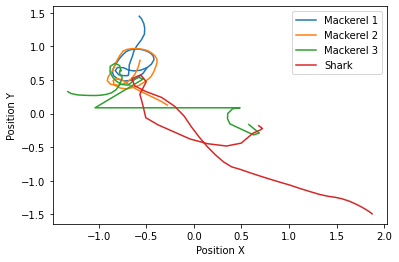

In [30]:
%pylab inline
import numpy as np

paths = [np.array(e.get_log('position')) for e in simulator.robots]

for path in paths:
    plot(path[:, 0], path[:, 1])
legend(["Mackerel 1", "Mackerel 2", "Mackerel 3", "Shark"])
    
xlabel("Position X")
ylabel("Position Y")

### Intensities of multiple needs against time

As explained above, in this project we prioritize schooling over foraging and anti-predation over schooling. We did some plots that are representative of the trade-offs between multiple needs for each of the three mackerels. The plots explain the changing priority with respect to the internal drives of the agents and increment in time. Therefore, in the beginning, the need to stay together (schooling behaviors) is seen. Over time, consuming food to gain energy becomes prior. The nature of security is fluctuating because it is dependent on the predator’s behavior. 

#### Mackerel 1

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Need')

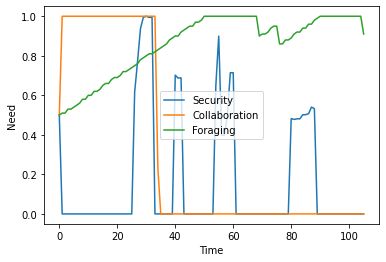

In [26]:
plot(prey1.get_log("security"))
plot(prey1.get_log("collaboration"))
plot(prey1.get_log("foraging"))
legend(["Security", "Collaboration", "Foraging"])

xlabel("Time")
ylabel("Need")

#### Mackerel 2

Text(0, 0.5, 'Need')

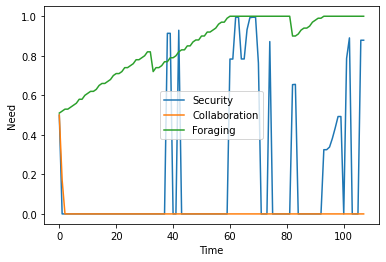

In [27]:
plot(prey2.get_log("security"))
plot(prey2.get_log("collaboration"))
plot(prey2.get_log("foraging"))
legend(["Security", "Collaboration", "Foraging"])

xlabel("Time")
ylabel("Need")

#### Mackerel 3

Text(0, 0.5, 'Need')

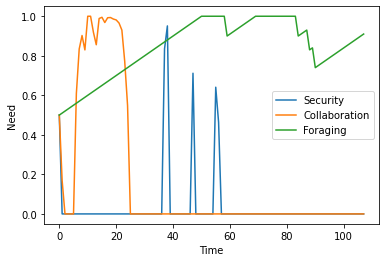

In [28]:
plot(prey3.get_log("security"))
plot(prey3.get_log("collaboration"))
plot(prey3.get_log("foraging"))
legend(["Security", "Collaboration", "Foraging"])

xlabel("Time")
ylabel("Need")

## 3 - Close session

In [ ]:
close_session(simulator)

# V - Results and discussions

## 1 - Demo

In summary, we successfully generate a formation of a triangular shoal that can serve as a proof of concept for implementing grouping behaviors without requiring the agents to perform any sort of communication or global perception. We also succeed in demonstrating some behavioral regulations and emergent dynamics that appear from the interaction of the different internal drives and external stimuli.

Click the below links to watch some recordings of the simulations:
#### [Schooling behaviors - Reynold rules without spheres and predator](https://www.youtube.com/watch?v=y85Nv1qDJ_4)
#### [Schooling behaviors - In the presence of spheres and predator 1](https://www.youtube.com/watch?v=VG6KSYwlaGw)
#### [Schooling behaviors - In the presence of spheres and predator 2](https://www.youtube.com/watch?v=Yv4_laPBaNY)


## 2 - Limitation 

- **Low polarity:** The Reynolds rules were not precisely replicated in our project. Our solution can ensure a good density of the school, but not a high polarity. The mackerels didn't perform perfect schooling movements of constantly heading towards the same direction. Given the constraints of local sensing and reactive behaviors, we should research further to come up with a better alignment rule, probably with a refuge/target destination or a leader.

- **Lack of prey identity:** Regarding the hunting behavior of the shark, the epuck can only detect a maximum number of two objects, and it also cannot tell whether the two proximity sensors are sensing the same individual prey or not. This lack of object identity is at the same time a limitation and an opportunity for future development. We can further research to come up with a future solution that allows the predator to identify moving objects, store their locations, and calculate the density of the school. 

## 3 - Future development

Some features we couldn't implement within the scope of this project since they can make the project over complicated and the trade-offs between behaviors can become hardly observable:
- **Mix-species shooling:** Taking advantage of various sensorimotor abilities of multiple species, as well as demonstrating the different ranking systems of different species. In this case, the flock does not consist of the same species but of several species that gain a benefit from each other. These associations would be characterized by a few sit-and-wait species that act as guardians and other species that actively search for food sources that are difficult to detect. Within the current scene, this idea can be done but might became a bit hard to observe, so we left it like this for now. 
- **Fight-or-flight response to predators:** We would like to demonstrate a richer anti-predation behavior repertoire. Fleeing behavior can be triggered by reducing the distance between a member of a flock and a predator if it is too far away from its school. Fighting behavior, on the other hand, is triggered when the predator's distance is too short to flee. Within the current scene, this idea became a bit hard to observe, so we left it like this for now.
- **Migration:** If time permits, we can make the school going towards a refuge or a target destination with richer food resources.

If we want the agents to have cognitive interactions with each other and fulfill several needs at the group level, we might need a more efficient simulation setup and a model that can account for how low-level dynamic processes (i.e what we observed here) interact with high-level strategic processes (e.g. memory and learning, prediction of environmental perturbations and adaption, goals and planning, send and handle notifications to get information from shoal mates, etc.). 